# Determining the Vpp and Frequency of a Wave + Plotting: 2018-10-04-Plasma_Chamber_results

In this Notebook we load the .csv file from the oscilloscope and then determine fundamental parameters of the waves - peak-to-peak voltage and the frequency.

This is based on a previous notebook I had written up.

In [53]:
# First import the necessary packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from scipy import stats
from scipy.signal import find_peaks

# Then load the data as a dataframe:
df_org = pd.read_csv('2018-10-04-Plasma_Chamber_results/ALL0002/F0002CH1.csv',header=None)    # Original signal
df_amp = pd.read_csv('2018-10-04-Plasma_Chamber_results/ALL0002/F0002CH4.csv',header=None)       # Amplified signal

In [6]:
# Investigate the first few rows to see what the data looks like
df_org.head(10)

,0,1,2,3,4,5
0,Record Length,2.500000e+03,NaN,-0.000001,-0.00120,NaN
1,Sample Interval,1.000000e-09,NaN,-0.000001,-0.00136,NaN
2,Trigger Point,1.250000000000e+03,NaN,-0.000001,-0.00120,NaN
3,NaN,NaN,NaN,-0.000001,-0.00160,NaN
4,NaN,NaN,NaN,-0.000001,-0.00120,NaN
5,NaN,NaN,NaN,-0.000001,-0.00112,NaN
6,Source,CH1,NaN,-0.000001,-0.00120,NaN
7,Vertical Units,V,NaN,-0.000001,-0.00112,NaN
8,Vertical Scale,2.000000e-03,NaN,-0.000001,-0.00104,NaN
9,Vertical Offset,0.000000e+00,NaN,-0.000001,-0.00120,NaN


The .csv file produced by the Tektronix 2024-B oscilloscope has the first two columns with information on the vertical and horizontal (or y and x) scales, offests and units used as well as model details. From this we can see that we really only want to keep columns named '3' and '4' (index 3 and 4) for the x and y data respectively. Therefore:

In [9]:
df_org.columns = ['titles','values','no_info1','time','V','no_info2']
df_amp.columns = df_org.columns

df_org_sig = df_org[['time','V']]
df_amp_sig = df_amp[['time','V']]

,time,V
0,-0.000001,-0.00120
1,-0.000001,-0.00136
2,-0.000001,-0.00120
3,-0.000001,-0.00160
4,-0.000001,-0.00120
5,-0.000001,-0.00112
6,-0.000001,-0.00120
7,-0.000001,-0.00112
8,-0.000001,-0.00104
9,-0.000001,-0.00120


In [13]:
# Let's double check for the original signal:
df_org_sig.head(5)

,time,V
0,-0.000001,-0.00120
1,-0.000001,-0.00136
2,-0.000001,-0.00120
3,-0.000001,-0.00160
4,-0.000001,-0.00120


In [12]:
# and the amplified signal:
df_amp_sig.head(5)

,time,V
0,-0.000001,-1.36
1,-0.000001,-1.38
2,-0.000001,-1.34
3,-0.000001,-1.36
4,-0.000001,-1.38


We can plot the two to get an idea of how well they match in phase:

In [ ]:
# Create function to plot the amplified signal against the original signal

# Font style
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 14}

#Function
def plot_amp_vs_org(x_data,y_amp_data,y_org_data,figheight,figwidth):
    plt.style.use('ggplot')
    plt.rc('font', **font)
    fig, ax1 = plt.subplots()
    
    color = 'tab:red'
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Amplified Signal - Voltage (V)', color=color)
    ax1.plot(x_data, y_amp_data, color=color)
    
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(color=color, linestyle='-', linewidth=0.5, axis='y')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('Original Signal - Voltage (V)', color=color)  # handled the x-label with ax1
    ax2.plot(x_data, y_org_data, color=color)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    fig.set_figheight(figheight)
    fig.set_figwidth(figwidth)
    return fig

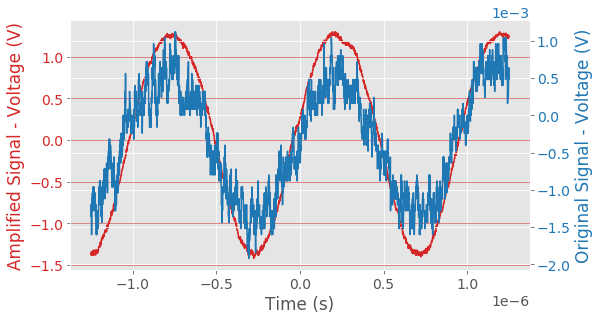

In [15]:
# Create figure:
Fig1 = plot_amp_vs_org(df_amp_sig['time'],df_amp_sig['V'],df_org_sig['V'],5,10)
# Display:
plt.show(Fig1)

Looks like the original and amplified signals are qutite well matched. This means that the amplification process is produced a relatively accurate reproduction of the original signal. This will allow us now to quantify the peak-to-peak voltage of the input and output signals so that we can determine the gain. The p2p_V_avg function (defined later down) does exactly that by finding the peaks in the signal and using a 'scipy' module called 'signal', specifically the method 'find_peaks'. After finding the peaks, average values of the voltage are taken around these peaks are determind and then the peak-to-peak voltage calculated by finding the distance between successive peaks.

We can write a function to automatically create a figure that displays the peaks identified in the original and amplified signals:

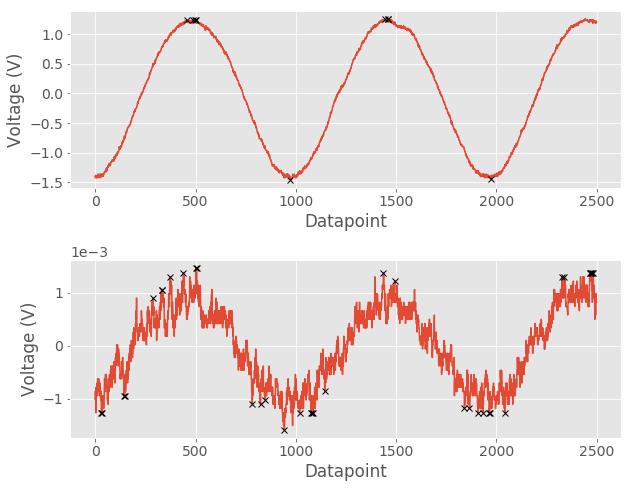

In [28]:
def peak_compare(org_sig,amp_sig,figheight,figwidth):
    org_mean = org_sig['V'] - org_sig['V'].mean()
    amp_mean = amp_sig['V'] - amp_sig['V'].mean()
    
    pos_org_sig = abs(org_mean - org_mean.mean())
    pos_amp_sig = abs(amp_mean - amp_mean.mean())
    
    org_peaks, _ = find_peaks(pos_org_sig, width = 6, prominence=pos_org_sig.mean())
    amp_peaks, _ = find_peaks(pos_amp_sig, width = 6, prominence=pos_amp_sig.mean())
    
    fig = plt.figure(figsize=(figheight,figwidth))
    #fig, ax = plt.subplots(4,1)
    plt.subplot(211)
    plt.plot(amp_mean)
    plt.plot(amp_peaks, amp_mean[amp_peaks], "x",color='k')
    plt.xlabel('Datapoint')
    plt.ylabel('Voltage (V)')
    #plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.subplot(212)
    plt.plot(org_mean)
    plt.plot(org_peaks, org_mean[org_peaks], "x",color='k')
    plt.xlabel('Datapoint')
    plt.ylabel('Voltage (V)')
    #plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.tight_layout()
    return fig


Fig4 = peak_compare(df_org_sig,df_amp_sig,9,7)

The above looks quite good, although there are additional peaks and troughs identified for the original signal.

Below we will now define the peak-to-peak voltage function. It will gives us the peak-to-peak voltage between each peak and the standard errors of the mean (SEMs) for each of the calculations.

In [29]:
# Function to calculate the index of the median position of the peaks 
def med_peak(waveform, percent):
    # Shift the data so that mean is zero:
    wf_mean0 =  waveform - waveform.mean()
    # For each of the values in the voltage data above, find the distance to the new mean
    wf_dist = abs(wf_mean0 - wf_mean0.mean())
    # wf_dist is now all positive therefore, one cannot differentiate between peak and trough
    # The aim now is to find the distance between successive peaks - this is the p2p voltage
    peaks, _ = find_peaks(wf_dist, width = 6, prominence=wf_dist.mean())
    # We now have the indexes of the peaks of wf_dist. Some of these indexes will point to the same
    # original peak or trough. Therefore we need to go through and find the median index of any
    # series of indexes that point to the same peak/trough. We will use the fact that the original
    # wf_mean0 data goes from positive to negative and back when transitioning from a peak to a 
    # trough:
    end_i = []
    for i in range(len(peaks)-1):
        if wf_mean0[peaks[i+1]]/wf_mean0[peaks[i]] < 0:
            end_i.append(i)
    median_peaks = []
    sem_peaks = []
    # Now we find the median peak indexes and standard deviation:
    for i in range(len(end_i)):
        if i == 0:
            median_peaks.append(int(np.median(peaks[0:end_i[i]+1])))
            sem_peaks.append(np.nan_to_num(stats.sem(peaks[0:end_i[i]+1])))
        else:
            median_peaks.append(int(np.median(peaks[end_i[i-1]+1:end_i[i]+1])))
            sem_peaks.append(np.nan_to_num(stats.sem(peaks[end_i[i-1]+1:end_i[i]+1])))
    # Compare SEM to the measurement error on the DSO of 2%, if less 
    #peak_sem = []
    #for sem in sem_peaks:
    #    if sem < len(df_org_sig['V'])*percent/2:
    #        peak_sem.append(len(df_org_sig['V'])*percent/2)
    #    else:
    #        peak_sem.append(sem)
    return median_peaks, sem_peaks

# Function to take in a 1D waveform and find the average peak-to-peak voltage
# Output is a list of the average value and the SEM as a tuple
def p2p_V_avg(waveform, waveform_4_peaks, percent):
    median_peaks, sem_peaks = med_peak(waveform_4_peaks,percent)
    # We will check if the SEM of the peaks are greater or less than the 2% error expected from the DSO.
    # If the SEM is larger, this will be the error that is used, otherwise it will be set at 2%
    # We will assume that the median index is within (percentx100)% of the true peak position and therefore, we
    # will now average the values of the voltage within (percentx100)% of the median index found. we will also
    # calculate the SEM for the values that have been averaged:
    band_idx = int(percent*len(waveform)/2)
    peak_avgs = []
    for peak_idx in median_peaks:
        low_b = peak_idx-band_idx
        up_b = peak_idx+band_idx
        p_sem_tup = (waveform[low_b:up_b].mean(),stats.sem(waveform[low_b:up_b]))
        peak_avgs.append(p_sem_tup)
        low_b = None
        up_b = None
        p_sem_tup = None
    # We now find the peak-to-peak voltage, taking the difference between successive peaks:
    p2p_V_list = []
    for avg_idx in range(len(peak_avgs)-1):
        V_p2p = abs(peak_avgs[avg_idx][0]-peak_avgs[avg_idx+1][0])
        sem_V = np.sqrt(peak_avgs[avg_idx][1]**2 + peak_avgs[avg_idx+1][1]**2) 
        p2p_V_list.append((V_p2p,sem_V))
    return p2p_V_list, peak_avgs

Define a function for calculating the frequency:

In [30]:
# Calculate the frequency of the wave
def freq_mean(x_time,y_waveform,percent):
    median_peaks, sem_peaks = med_peak(y_waveform,percent)

    dist_betw_peaks = [median_peaks[i+2] - median_peaks[i] for i in range(len(median_peaks)-2)]
    sem_dist = [np.sqrt(sem_peaks[i+2]**2 + sem_peaks[i]**2) for i in range(len(sem_peaks)-2)]
    time_betw_xval = x_time[1] - x_time[0]

    # Period
    periods = [dist*time_betw_xval for dist in dist_betw_peaks]
    sem_p = [sem*time_betw_xval for sem in sem_dist]
    percent_err = [sem/period for sem,period in zip(sem_p,periods)]
    freq = [x**-1 for x in periods]
    mean_freq = np.array(freq).mean()
    freq_err = mean_freq*(np.sqrt(np.array(sum([x**2 for x in percent_err]))))
    
    return (mean_freq, freq_err)

In [48]:
# Amplified signal p2p voltages:
p2p_V_amp, peak_avg_amp = p2p_V_avg(df_amp_sig['V'],df_amp_sig['V'],0.02)
print('Mean P2P Voltage = '+str(np.mean([x[0] for x in p2p_V_amp])))
print('Percentage Error = '+str(p2p_V_amp[0][1]/p2p_V_amp[0][0]))

Mean P2P Voltage = 2.6178000000000003
Percentage Error = 0.0014749051709454278


C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [37]:
# Original signal p2p voltages:
p2p_V_org, peak_avg_org = p2p_V_avg(df_org_sig['V'],df_org_sig['V'],0.02)
print('Mean P2P Voltage = '+str(np.array([x[0] for x in p2p_V_org]).mean()))
print('Percentage Error = '+str(p2p_V_org[0][1]/p2p_V_org[0][0]))

Mean P2P Voltage = 0.0015676000000000002
Percentage Error = 0.05060779263850316


In [49]:
# Calcualte average gain
mean_V_amp = np.array([x[0] for x in p2p_V_amp]).mean()
mean_V_org = np.array([x[0] for x in p2p_V_org]).mean()
gain_mean = mean_V_amp/mean_V_org
# Uncertainties in average gain calculation
mean_err_V_amp = np.sqrt(np.sum(np.array([x[1]**2 for x in p2p_V_amp])))/(len(p2p_V_amp))
mean_err_V_org = np.sqrt(np.sum(np.array([x[1]**2 for x in p2p_V_org])))/(len(p2p_V_org))
gain_p2p_sem = gain_mean*np.sqrt( (mean_err_V_amp/mean_V_amp) + ((mean_err_V_org/mean_V_org)) )

In [50]:
# Define the column names for the table
column_name = ['Amplified Frequency (Hz)','SEM_Freq','Original pk-pk Voltage (V)','SEM_Original','Amplified pk-pk Voltage (V)','SEM_Amplified','Gain (Amplified/Original)','SEM_Gain']
# Create table
info_g = np.array([mean_freq,sem_freq,mean_V_org, mean_err_V_org, mean_V_amp, mean_err_V_amp, gain_mean, gain_p2p_sem])
df_info = pd.DataFrame(info_g, index = column_name, columns = ['Gain Achieved by Amplifier'])
pd.set_option('display.float_format', lambda x: '{:.2e}'.format(x) if x<0.01  else '{:.3g}'.format(x))
df_info

,Gain Achieved by Amplifier
Amplified Frequency (Hz),1.03e+06
SEM_Freq,1.31e+04
Original pk-pk Voltage (V),1.57e-03
SEM_Original,2.40e-05
Amplified pk-pk Voltage (V),2.62
SEM_Amplified,2.86e-03
Gain (Amplified/Original),1.67e+03
SEM_Gain,214
